In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import pandas as pd

In [12]:
filepath = './data/sentiment_analysis/yelp_labelled.txt'

df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    
print('-----,,,,,,,,-------',df)

-----,,,,,,,,-------                                               sentence  label
0                             Wow... Loved this place.      1
1                                   Crust is not good.      0
2            Not tasty and the texture was just nasty.      0
3    Stopped by during the late May bank holiday of...      1
4    The selection on the menu was great and so wer...      1
5       Now I am getting angry and I want my damn pho.      0
6                Honeslty it didn't taste THAT fresh.)      0
7    The potatoes were like rubber and you could te...      0
8                            The fries were great too.      1
9                                       A great touch.      1
10                            Service was very prompt.      1
11                                  Would not go back.      0
12   The cashier had no care what so ever on what I...      0
13   I tried the Cape Cod ravoli, chicken,with cran...      1
14   I was disgusted because I was pretty sure th

In [13]:
from sklearn.model_selection import train_test_split


sentences = df['sentence'].values
y = df['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

In [14]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

Of all the dishes, the salmon was the best, but all were great.
[11, 43, 1, 171, 1, 283, 3, 1, 47, 26, 43, 24, 22]


In [15]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[  1  10   3 282 739  25   8 208  30  64 459 230  13   1 124   5 231   8
  58   5  67   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [16]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           87350     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 87,871
Trainable params: 87,871
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 1.0000
Testing Accuracy:  0.7920


In [18]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

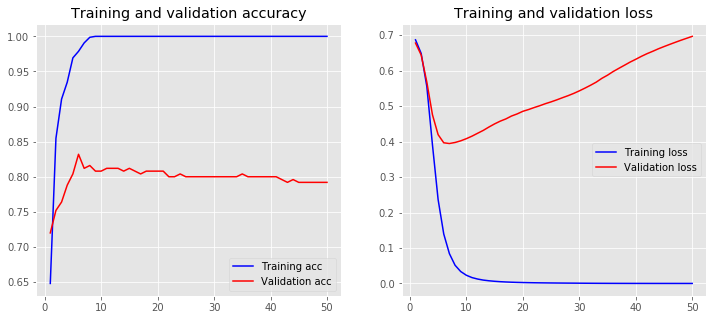

In [19]:
plot_history(history)